In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

from helpers import load_cascades, cascade_source
from sample_pool import TreeSamplePool
from tree_stat import TreeBasedStatistics
from graph_helpers import load_graph_by_name, k_hop_neighbors
from inference import infection_probability

from joblib import Parallel, delayed
from graph_tool.centrality import pagerank
from tqdm import tqdm
from sklearn.metrics import average_precision_score
from collections import defaultdict
from random_steiner_tree.util import from_gt



In [3]:
graph_name = 'grqc'
g = load_graph_by_name(graph_name)

In [4]:
n_samples= 250
sampling_method = 'loop_erased'


In [5]:
def pagerank_scores(g, obs):
    pers = g.new_vertex_property('float')
    for o in obs:
        pers[o] = 1 / len(obs)
    rank = pagerank(g, pers=pers)

    for o in obs:
        rank[o] = 0  # cannot select obs nodes
    p = rank.a / rank.a.sum()    
    return p

In [6]:
def build_cascade_source_sampler(g, obs, c, *args):
    def aux():
        return cascade_source(c)
    return aux

def build_root_sampler_by_pagerank_score(g, obs, c, p):
    def aux():
        return np.random.choice(np.arange(g.num_vertices()), size=1, p=p)[0]
    return aux

def build_earlier_root_sampler(g, obs, c, *args):
    def f():
        return min(obs, key=lambda o: c[o])
    return f

def build_early_nbrs_sampler(g, obs, c, *args, k=1):
    earliest_node = min(obs, key=lambda o: c[o])
    nbrs = list(k_hop_neighbors(earliest_node, g, k=k)) + [earliest_node]

    def f():
        return random.choice(nbrs)
    return f
    
root_samplers = {'random': (lambda *things: None), 
                 'source': build_cascade_source_sampler,
                 'early_nbrs': build_early_nbrs_sampler,
                 'pagerank': build_root_sampler_by_pagerank_score
                }

In [7]:
def one_run_for_cascade(obs, c, pagerank):
    """pass pagerank in because if pagerank and joblib.Parallel cannot be run together"""
    estimator = TreeBasedStatistics(g)
    gi = from_gt(g)
    sampler = TreeSamplePool(g, n_samples=n_samples,
                             method=sampling_method,
                             gi=gi,
                             return_tree_nodes=True)

    ans = {}
    for name, root_sampler_builder in root_samplers.items():
        root_sampler = root_sampler_builder(g, obs, c, pagerank)
        sampler.fill(obs,
                     root_sampler=root_sampler)
        estimator.build_matrix(sampler.samples)
        probas = infection_probability(g, obs, sampler, error_estimator=estimator)

        # evaluation
        obs = set(obs)
        infected = (c >= 0).nonzero()[0]
        y_true = np.zeros((len(c), ))
        y_true[infected] = 1

        mask = np.array([(i not in obs) for i in range(len(c))])
        ans[name] = average_precision_score(y_true[mask], probas[mask])
    return ans


In [8]:
def one_run_for_cascade_dir(cascade_dir):    
    cs = load_cascades(cascade_dir)
    gi = from_gt(g)
    
    records = Parallel(n_jobs=-1)(delayed(one_run_for_cascade)(obs, c, pagerank_scores(g, obs))
                                  for cid, (obs, c) in tqdm(cs, total=96))
    df = pd.DataFrame.from_records(records)
    
    return df

In [9]:
infection_fractions = [0.01, 0.02, 0.04, 0.08, 0.16]
cascade_dirs = ['cascade/grqc-msi-s{}-o0.1/'.format(i) for i in infection_fractions]

In [10]:
dfs = []
for cascade_dir in cascade_dirs:
    dfs.append(one_run_for_cascade_dir(cascade_dir))

100%|██████████| 96/96 [00:52<00:00,  1.96it/s]


In [11]:
from cycler import cycler
plt.rc('axes',
       prop_cycle=(
           cycler('color', ['b', 'g', 'r', 'y', 'g', 'b']) +
           cycler('linestyle', ['-', '-', '-', '-', '--', '-']) +
           cycler('marker', ['o', 'v', 'x', 's', 'o', '*'])
       ))

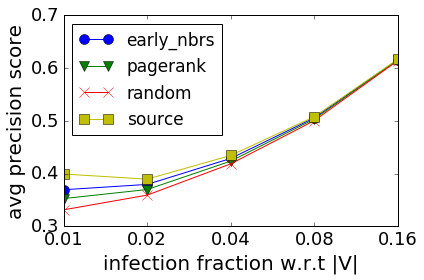

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111)
rows = np.array([df.mean().as_matrix() for df in dfs]).T
for r in rows:
    ax.plot(r, markersize=10)

ax.set_xlabel('infection fraction w.r.t |V|')
ax.set_ylabel('avg precision score')
ax.legend(list(dfs[0].columns), loc='best', fontsize=17)
ax.set_xticklabels(infection_fractions)

for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(18)

ax.xaxis.label.set_fontsize(20)
ax.yaxis.label.set_fontsize(20)
ax.locator_params(axis='y', nbins=4)
ax.locator_params(axis='x', nbins=5)
fig.tight_layout()

fig.savefig('figs/root-effects.pdf')

In [13]:
for f, df in zip(infection_fractions, dfs):
    print('cascade size: {}x|V|'.format(f))
    print()
    print(df.mean().sort_values(ascending=False))
    print('--'*10)
    

cascade size: 0.01x|V|

source        0.399118
early_nbrs    0.369346
pagerank      0.352631
random        0.331267
dtype: float64
--------------------
cascade size: 0.02x|V|

source        0.389468
early_nbrs    0.379448
pagerank      0.369769
random        0.359145
dtype: float64
--------------------
cascade size: 0.04x|V|

source        0.434390
early_nbrs    0.428704
pagerank      0.423641
random        0.418424
dtype: float64
--------------------
cascade size: 0.08x|V|

source        0.507749
early_nbrs    0.505600
pagerank      0.503352
random        0.500304
dtype: float64
--------------------
cascade size: 0.16x|V|

source        0.616757
early_nbrs    0.615772
pagerank      0.615526
random        0.614185
dtype: float64
--------------------


In [14]:
def build_fixed_node_as_root(n):
    def aux():
        return n
    return aux

In [15]:
degree = g.degree_property_map('out')
def tree_proba(degree, tree):
    prod = np.product([degree[e.source()] for e in tree.edges()])
    return 1 / prod

In [16]:
def build_root_sampler_by_pagerank_score(g, obs):
    pers = g.new_vertex_property('float')
    for o in obs:
        pers[o] = 1 / len(obs)
    rank = pagerank(g, pers=pers)
    
    for o in obs:
        rank[o] = 0  # cannot select obs nodes
    p = rank.a / rank.a.sum()
    def aux():
        return np.random.choice(np.arange(g.num_vertices()), size=1, p=p)[0]
    return aux
        

In [17]:
############
## too slow!!  12 hours
############

sampler = TreeSamplePool(g, n_samples=100,
                         method=sampling_method,
                         gi=gi,
                         return_tree_nodes=False)

scores = np.zeros(g.num_vertices())
for root in tqdm(g.vertices(), total=g.num_vertices()):
    root = int(root)
    if root in obs:
        continue        

    sampler.fill(obs,
                 root_sampler=build_fixed_node_as_root(root))
    scores[root] = sum(tree_proba(degree, tree) for tree in sampler.samples)
        
    # probas = infection_probability(g, obs, sampler, error_estimator=estimator)


NameError: name 'gi' is not defined